**Data Augmentation**

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Base path where client datasets are stored
client_base = r"C:\Users\karin\Documents\Federated_learning\clients"

# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(20),                     # rotation range 20 degrees
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),                         # width and height shift 20%
        shear=20,                                     # shear 20 degrees
        fill=0                                        # fill empty pixels with black
    ),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.2)),  # zoom range ~20%
    transforms.RandomHorizontalFlip(p=0.5),           # horizontal flip
    transforms.ToTensor()
])

# For validation/testing (no augmentation, only resize and tensor)
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create DataLoaders for each client
client_loaders = {}
batch_size = 16

for client in os.listdir(client_base):
    client_path = os.path.join(client_base, client, "Training")
    if not os.path.isdir(client_path):
        continue

    dataset = datasets.ImageFolder(client_path, transform=train_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    client_loaders[client] = loader

print("DataLoaders with augmentation created for clients:", list(client_loaders.keys()))


DataLoaders with augmentation created for clients: ['client1', 'client2', 'client3', 'client4']


**Feature Extraction**

In [2]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pretrained ResNet (without final classification layer)
resnet = models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]  # remove final FC layer
feature_extractor = nn.Sequential(*modules).to(device)
feature_extractor.eval()  # set to eval mode

# Example: extract features for a batch
for client, loader in client_loaders.items():
    for images, labels in loader:
        images = images.to(device)
        with torch.no_grad():
            features = feature_extractor(images)  # shape: [batch_size, 512, 1, 1]
            features = features.view(features.size(0), -1)  # flatten to [batch_size, 512]


c:\Users\karin\Documents\Federated_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karin\Documents\Federated_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Feature Selection**

In [3]:
client_features_dict = {}

for client, loader in client_loaders.items():
    all_features = []
    all_labels = []
    
    for images, labels in loader:
        images = images.to(device)
        with torch.no_grad():
            features = feature_extractor(images)           # [batch_size, 512, 1, 1]
            features = features.view(features.size(0), -1) # flatten to [batch_size, 512]
        
        all_features.append(features.cpu())  # move to CPU and store
        all_labels.append(labels)            # labels are already CPU tensors

    # Stack all batches to one tensor per client
    client_features_dict[client] = {
        "features": torch.cat(all_features, dim=0),  # [total_images, 512]
        "labels": torch.cat(all_labels, dim=0)       # [total_images]
    }

print("Feature extraction complete. Example shapes:")
for client, data in client_features_dict.items():
    print(client, data["features"].shape, data["labels"].shape)


Feature extraction complete. Example shapes:
client1 torch.Size([1000, 512]) torch.Size([1000])
client2 torch.Size([400, 512]) torch.Size([400])
client3 torch.Size([200, 512]) torch.Size([200])
client4 torch.Size([50, 512]) torch.Size([50])


**Feature Selection and Federated Learning**

In [28]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import numpy as np

# -----------------------------
# Determine fixed PCA dimension
# -----------------------------
min_samples = min([client_features_dict[c]['features'].shape[0] for c in client_features_dict])
fixed_n_components = min(50, min_samples)  # adjust 50 or lower if some client has very few images
print("Fixed PCA components:", fixed_n_components)

# -----------------------------
# Apply PCA per client
# -----------------------------
client_reduced_features = {}
for client in client_features_dict:
    X = client_features_dict[client]['features'].numpy()
    y = client_features_dict[client]['labels'].numpy()
    
    pca = PCA(n_components=fixed_n_components)
    X_reduced = pca.fit_transform(X)
    
    client_reduced_features[client] = {
        "features": X_reduced,
        "labels": y
    }
    
    print(client, "reduced features shape:", X_reduced.shape)

# -----------------------------
# Train Test Split
# -----------------------------

from sklearn.model_selection import train_test_split

client_train_data = {}
client_val_data = {}

for client in client_reduced_features:
    X = client_reduced_features[client]["features"]
    y = client_reduced_features[client]["labels"]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    client_train_data[client] = {"features": X_train, "labels": y_train}
    client_val_data[client] = {"features": X_val, "labels": y_val}


# # -----------------------------
# # Define MLP
# # -----------------------------
# class MLP(nn.Module):
#     def __init__(self, input_dim=fixed_n_components, num_classes=4):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, num_classes)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # -----------------------------
# # FedAvg function
# # -----------------------------
# def fed_avg(weights_list):
#     avg_weights = {}
#     for key in weights_list[0].keys():
#         avg_weights[key] = sum([w[key] for w in weights_list]) / len(weights_list)
#     return avg_weights

# # -----------------------------
# # Initialize global model
# # -----------------------------
# global_model = MLP(input_dim=fixed_n_components, num_classes=4)
# global_weights = global_model.state_dict()

# # -----------------------------
# # Validation Function
# # -----------------------------
# def evaluate_model(model, X, y):
#     model.eval()
#     X = torch.tensor(X, dtype=torch.float32)
#     y = torch.tensor(y, dtype=torch.long)
#     with torch.no_grad():
#         outputs = model(X)
#         loss = nn.CrossEntropyLoss()(outputs, y)
#         preds = torch.argmax(outputs, dim=1)
#         acc = (preds == y).float().mean().item()
#     return loss.item(), acc



# # -----------------------------
# # Federated learning loop
# # -----------------------------

# num_rounds = 175
# local_epochs = 3
# learning_rate = 0.01

# global_history = []  # to store per-round validation accuracy
# best_acc = 0.0

# for round in range(num_rounds):
#     local_weights = []
#     print(f"--- Round {round+1} ---")
    
#     # --- Local training per client ---
#     for client in client_train_data:
#         X_train = torch.tensor(client_train_data[client]['features'], dtype=torch.float32)
#         y_train = torch.tensor(client_train_data[client]['labels'], dtype=torch.long)
        
#         model = MLP(input_dim=fixed_n_components, num_classes=4)
#         model.load_state_dict(copy.deepcopy(global_weights))
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#         criterion = nn.CrossEntropyLoss()
        
#         model.train()  # <-- train mode for local updates
#         for epoch in range(local_epochs):
#             optimizer.zero_grad()
#             outputs = model(X_train)
#             loss = criterion(outputs, y_train)
#             loss.backward()
#             optimizer.step()
        
#         local_weights.append(copy.deepcopy(model.state_dict()))
    
#     # --- FedAvg aggregation ---
#     global_weights = fed_avg(local_weights)
#     global_model.load_state_dict(global_weights)
    
#     # --- Validation ---
#     global_model.eval()  # <-- eval mode för global modellen

#     val_accuracies = []
#     for client in client_val_data:
#         X_val = client_val_data[client]['features']
#         y_val = client_val_data[client]['labels']
#         _, acc = evaluate_model(global_model, X_val, y_val)
#         val_accuracies.append(acc)
    
#     avg_val_acc = np.mean(val_accuracies)
#     global_history.append(avg_val_acc)
    
#     print(f"Round {round+1}: Average Validation Accuracy = {avg_val_acc:.4f}")

#     # --- Save best global model ---
#     if avg_val_acc > best_acc:
#         best_acc = avg_val_acc
#         torch.save(global_model.state_dict(), "best_global_model.pth")
#         print(f"New best model saved with accuracy: {best_acc:.4f}")


# num_rounds = 150
# local_epochs = 3
# learning_rate = 0.01

# for round in range(num_rounds):
#     local_weights = []
#     print(f"--- Round {round+1} ---")
    
#     for client in client_reduced_features:
#         X = torch.tensor(client_reduced_features[client]['features'], dtype=torch.float32)
#         y = torch.tensor(client_reduced_features[client]['labels'], dtype=torch.long)
        
#         # Initialize local model with global weights
#         model = MLP(input_dim=fixed_n_components, num_classes=4)
#         model.load_state_dict(copy.deepcopy(global_weights))
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#         criterion = nn.CrossEntropyLoss()
        
#         # Local training
#         for epoch in range(local_epochs):
#             optimizer.zero_grad()
#             outputs = model(X)
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()
        
#         local_weights.append(copy.deepcopy(model.state_dict()))
    
#     # FedAvg aggregation
#     global_weights = fed_avg(local_weights)
#     global_model.load_state_dict(global_weights)

# print("Federated training complete. Global model ready for evaluation.")


Fixed PCA components: 50
client1 reduced features shape: (1000, 50)
client2 reduced features shape: (400, 50)
client3 reduced features shape: (200, 50)
client4 reduced features shape: (50, 50)


In [29]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,5))
# plt.plot(global_history, label="Global Validation Accuracy")
# plt.xlabel("Round")
# plt.ylabel("Accuracy")
# plt.title("Federated Learning Validation Accuracy per Round")
# plt.legend()
# plt.grid(True)
# plt.show()



--- Round 1 ---
Round 1: Average Validation Accuracy = 0.2350
New best model saved with accuracy: 0.2350

--- Round 2 ---
Round 2: Average Validation Accuracy = 0.2375
New best model saved with accuracy: 0.2375

--- Round 3 ---
Round 3: Average Validation Accuracy = 0.2525
New best model saved with accuracy: 0.2525

--- Round 4 ---
Round 4: Average Validation Accuracy = 0.2556
New best model saved with accuracy: 0.2556

--- Round 5 ---
Round 5: Average Validation Accuracy = 0.2538

--- Round 6 ---
Round 6: Average Validation Accuracy = 0.2675
New best model saved with accuracy: 0.2675

--- Round 7 ---
Round 7: Average Validation Accuracy = 0.2688
New best model saved with accuracy: 0.2688

--- Round 8 ---
Round 8: Average Validation Accuracy = 0.2613

--- Round 9 ---
Round 9: Average Validation Accuracy = 0.2644

--- Round 10 ---
Round 10: Average Validation Accuracy = 0.2656

--- Round 11 ---
Round 11: Average Validation Accuracy = 0.2694
New best model saved with accuracy: 0.2694

-

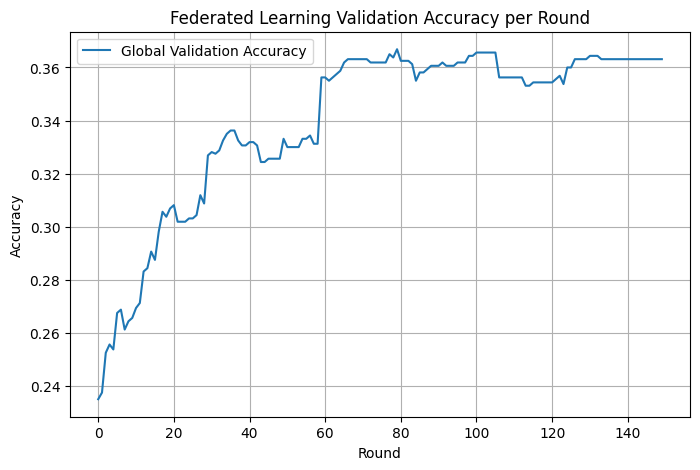

In [36]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Define MLP
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=fixed_n_components, num_classes=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -----------------------------
# FedAvg
# -----------------------------
def fed_avg(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = sum([w[key] for w in weights_list]) / len(weights_list)
    return avg_weights

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X, y):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(X)
        loss = nn.CrossEntropyLoss()(outputs, y)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == y).float().mean().item()
    return loss.item(), acc

# -----------------------------
# Federated Learning Parameters
# -----------------------------
num_rounds = 150
local_epochs = 3
learning_rate = 0.01

# Initialize global model
global_model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
global_weights = global_model.state_dict()

global_history = []
best_acc = 0.0

# -----------------------------
# Class weights per client (for imbalance)
# -----------------------------
client_class_weights = {}
num_classes = 4
for client in client_train_data:
    labels = client_train_data[client]["labels"]
    counts = np.bincount(labels, minlength=num_classes)
    weights = 1.0 / (counts + 1e-6)  # avoid division by zero
    weights = weights / weights.sum() * num_classes  # normalize
    client_class_weights[client] = torch.tensor(weights, dtype=torch.float32).to(device)

# -----------------------------
# Federated Training Loop
# -----------------------------
for round in range(num_rounds):
    local_weights = []
    print(f"\n--- Round {round+1} ---")
    
    # Local Training per client
    for client in client_train_data:
        X_train = torch.tensor(client_train_data[client]['features'], dtype=torch.float32).to(device)
        y_train = torch.tensor(client_train_data[client]['labels'], dtype=torch.long).to(device)
        
        model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
        model.load_state_dict(copy.deepcopy(global_weights))
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(weight=client_class_weights[client])
        
        model.train()
        for epoch in range(local_epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        local_weights.append(copy.deepcopy(model.state_dict()))
    
    # FedAvg aggregation
    global_weights = fed_avg(local_weights)
    global_model.load_state_dict(global_weights)
    
    # -----------------------------
    # Global Evaluation on all clients' validation sets
    # -----------------------------
    val_accuracies = []
    for client in client_val_data:
        X_val = client_val_data[client]['features']
        y_val = client_val_data[client]['labels']
        _, acc = evaluate_model(global_model, X_val, y_val)
        val_accuracies.append(acc)
    
    avg_val_acc = np.mean(val_accuracies)
    global_history.append(avg_val_acc)
    
    print(f"Round {round+1}: Average Validation Accuracy = {avg_val_acc:.4f}")
    
    # Save the best global model
    if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        torch.save(global_model.state_dict(), "best_global_model.pth")
        print(f"New best model saved with accuracy: {best_acc:.4f}")

# -----------------------------
# Plot Global Accuracy History
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(global_history, label="Global Validation Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Federated Learning Validation Accuracy per Round")
plt.legend()
plt.grid(True)
plt.show()


**Model Evaluation**

In [37]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# -----------------------------
# Step 1: Evaluate local models (trained individually per client)
# -----------------------------
print("=== Local Model Evaluation ===")
local_model_performance = {}

for client in client_reduced_features:
    # Initialize a new MLP for this client
    model = MLP(input_dim=fixed_n_components, num_classes=4).to(device)
    
    # Train locally (same as in federated loop)
    X = torch.tensor(client_reduced_features[client]['features'], dtype=torch.float32).to(device)
    y = torch.tensor(client_reduced_features[client]['labels'], dtype=torch.long).to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    model.train()
    for epoch in range(5):  # local training epochs
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        loss_val = criterion(outputs, y).item()
        acc_val = (preds == y).float().mean().item()
    
    local_model_performance[client] = {"loss": loss_val, "accuracy": acc_val}
    print(f"{client} - Loss: {loss_val:.4f}, Accuracy: {acc_val:.4f}")

# -----------------------------
# Step 2: Evaluate global federated model
# -----------------------------
print("\n=== Global Federated Model Evaluation ===")
global_model.eval()

for client in client_reduced_features:
    X = torch.tensor(client_reduced_features[client]['features'], dtype=torch.float32).to(device)
    y = torch.tensor(client_reduced_features[client]['labels'], dtype=torch.long).to(device)
    
    with torch.no_grad():
        outputs = global_model(X)
        _, preds = torch.max(outputs, 1)
        loss_val = criterion(outputs, y).item()
        acc_val = (preds == y).float().mean().item()
    
    print(f"{client} - Loss: {loss_val:.4f}, Accuracy: {acc_val:.4f}")

# -----------------------------
# Step 3: Global evaluation across all clients combined
# -----------------------------
X_all = np.vstack([client_reduced_features[c]['features'] for c in client_reduced_features])
y_all = np.hstack([client_reduced_features[c]['labels'] for c in client_reduced_features])

X_all_t = torch.tensor(X_all, dtype=torch.float32).to(device)
y_all_t = torch.tensor(y_all, dtype=torch.long).to(device)

with torch.no_grad():
    outputs = global_model(X_all_t)
    _, preds = torch.max(outputs, 1)
    loss_all = criterion(outputs, y_all_t).item()
    acc_all = (preds == y_all_t).float().mean().item()

print(f"\nGlobal Evaluation (all clients combined) - Loss: {loss_all:.4f}, Accuracy: {acc_all:.4f}")
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_all_t.cpu().numpy(), preds.cpu().numpy(),
                            target_names=['glioma','meningioma','notumor','pituitary']))


=== Local Model Evaluation ===
client1 - Loss: 1.3602, Accuracy: 0.2840
client2 - Loss: 1.3177, Accuracy: 0.3925
client3 - Loss: 1.3474, Accuracy: 0.2850
client4 - Loss: 1.3289, Accuracy: 0.4600

=== Global Federated Model Evaluation ===
client1 - Loss: 1.3077, Accuracy: 0.3710
client2 - Loss: 1.1507, Accuracy: 0.4700
client3 - Loss: 1.2521, Accuracy: 0.4500
client4 - Loss: 0.8301, Accuracy: 0.7200

Global Evaluation (all clients combined) - Loss: 1.2484, Accuracy: 0.4152

Classification Report:
              precision    recall  f1-score   support

      glioma       0.66      0.37      0.47       760
  meningioma       0.23      0.38      0.29       265
     notumor       0.32      0.52      0.40       235
   pituitary       0.45      0.46      0.45       390

    accuracy                           0.42      1650
   macro avg       0.41      0.43      0.40      1650
weighted avg       0.49      0.42      0.43      1650

